In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df = pd.read_csv("kf_final_transaction.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [18]:
df.head(10)

,transaction_id,date,branch_id,customer_name,product_id,price,discount_percentage,rating
0,TRX5844188,2023-09-07,88605,Elizabeth Thomas,KF260,118700,0.05,3.0
1,TRX6182886,2022-11-07,27840,Andrew Martinez,KF492,751900,0.07,4.8
2,TRX7691180,2023-05-30,62913,Charles Reynolds,KF540,744200,0.03,3.3
3,TRX3205743,2022-11-28,31604,Casey Cochran,KF389,761700,0.06,3.5
4,TRX3644533,2023-05-28,20322,Rebecca Moore,KF854,681000,0.13,4.1
5,TRX1090520,2022-05-16,34490,Jacob Robinson,KF201,78400,0.06,4.8
6,TRX2800835,2023-10-11,47342,Susan Morris,KF576,353300,0.07,4.6
7,TRX2179171,2020-09-01,41296,Amanda Leon,KF134,832800,0.01,4.5
8,TRX4221759,2023-04-18,76684,Todd Ferrell,KF248,215100,0.01,4.9
9,TRX9341056,2022-11-07,55995,Samuel Edwards,KF289,695100,0.10,3.6


In [19]:
df['net_amount'] = df['price'] * (1 - df['discount_percentage'] / 100)
df['net_amount'] = np.maximum(df['net_amount'], 0)

In [20]:
tx_level = df.groupby(['customer_name', 'transaction_id'], as_index=False).agg(
    tx_date=('date', 'max'),
    tx_amount=('net_amount', 'sum'))

In [21]:
# Tentukan snapshot date (tanggal acuan RFM)
snapshot_date = tx_level['tx_date'].max().normalize()

# Agregasi per customer
rfm = tx_level.groupby('customer_name', as_index=False).agg(
    last_date=('tx_date', 'max'),
    frequency=('transaction_id', 'nunique'),
    monetary=('tx_amount', 'sum')
)

# Recency dalam hari
rfm['recency'] = (snapshot_date - rfm['last_date']).dt.days

In [22]:
def safe_qcut(series, q, labels):
    try:
        return pd.qcut(series, q, labels=labels)
    except ValueError:
        return pd.cut(series, q, labels=labels, duplicates="drop")

rfm['R_score'] = safe_qcut(rfm['recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_score'] = safe_qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_score'] = safe_qcut(rfm['monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

rfm['RFM_code'] = rfm['R_score']*100 + rfm['F_score']*10 + rfm['M_score']

In [23]:
def assign_segment(row):
    R, F, M = row['R_score'], row['F_score'], row['M_score']
    if R >= 4 and F >= 4 and M >= 4: return 'Champions'
    if F >= 4 and R >= 3: return 'Loyal'
    if M >= 4 and F <= 3: return 'Big Spenders'
    if R >= 4 and F <= 2: return 'New Customers'
    if R <= 2 and (F >= 4 or M >= 4): return 'At Risk'
    if R == 1 and F <= 2 and M <= 2: return 'Hibernating'
    return 'Others'

rfm['segment'] = rfm.apply(assign_segment, axis=1)

In [24]:
rfm = rfm.sort_values('monetary', ascending=False)
rfm.to_csv("rfm_results.csv", index=False)

print(rfm.head(10))

            customer_name  last_date  frequency      monetary  recency  \
178262      Michael Smith 2023-12-24        316  1.618214e+08        6   
65732         David Smith 2023-12-22        215  1.202284e+08        8   
177777    Michael Johnson 2023-12-25        219  1.102736e+08        5   
116196     Jennifer Smith 2023-12-26        191  1.061659e+08        4   
124893         John Smith 2023-11-30        198  1.058489e+08       30   
177297      Michael Brown 2023-12-29        184  9.579292e+07        1   
108169        James Smith 2023-12-27        198  9.411268e+07        3   
177781      Michael Jones 2023-12-28        183  9.314684e+07        2   
178406   Michael Williams 2023-12-17        182  9.299600e+07       13   
51435   Christopher Smith 2023-12-23        175  9.252304e+07        7   

        R_score  F_score  M_score  RFM_code    segment  
178262        5        5        5       555  Champions  
65732         5        5        5       555  Champions  
177777        

In [25]:
order = ["Champions","Loyal","Big Spenders","New Customers","At Risk","Hibernating","Others"]

seg_counts = (
    rfm["segment"].value_counts()
       .rename_axis("segment")
       .reset_index(name="count")
)
seg_counts["percent"] = (seg_counts["count"] / seg_counts["count"].sum() * 100).round(2)

seg_counts["segment"] = pd.Categorical(seg_counts["segment"], categories=order, ordered=True)
seg_counts = seg_counts.sort_values("segment").reset_index(drop=True)

display(seg_counts)
seg_counts.to_csv("rfm_segment_counts.csv", index=False)

,segment,count,percent
0,Champions,56764,21.45
1,Loyal,30461,11.51
2,Big Spenders,18246,6.90
3,New Customers,23816,9.00
4,At Risk,18615,7.04
5,Hibernating,20534,7.76
6,Others,96165,36.34


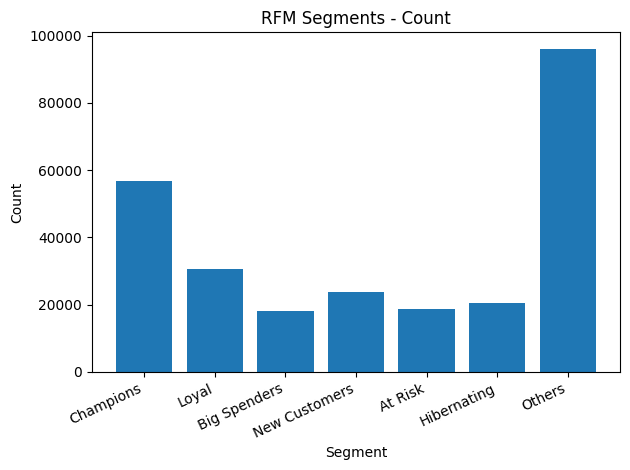

In [26]:
plt.figure()
plt.bar(seg_counts["segment"].astype(str), seg_counts["count"])
plt.title("RFM Segments - Count")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.savefig("rfm_segment_counts_bar.png", dpi=150)
plt.show()

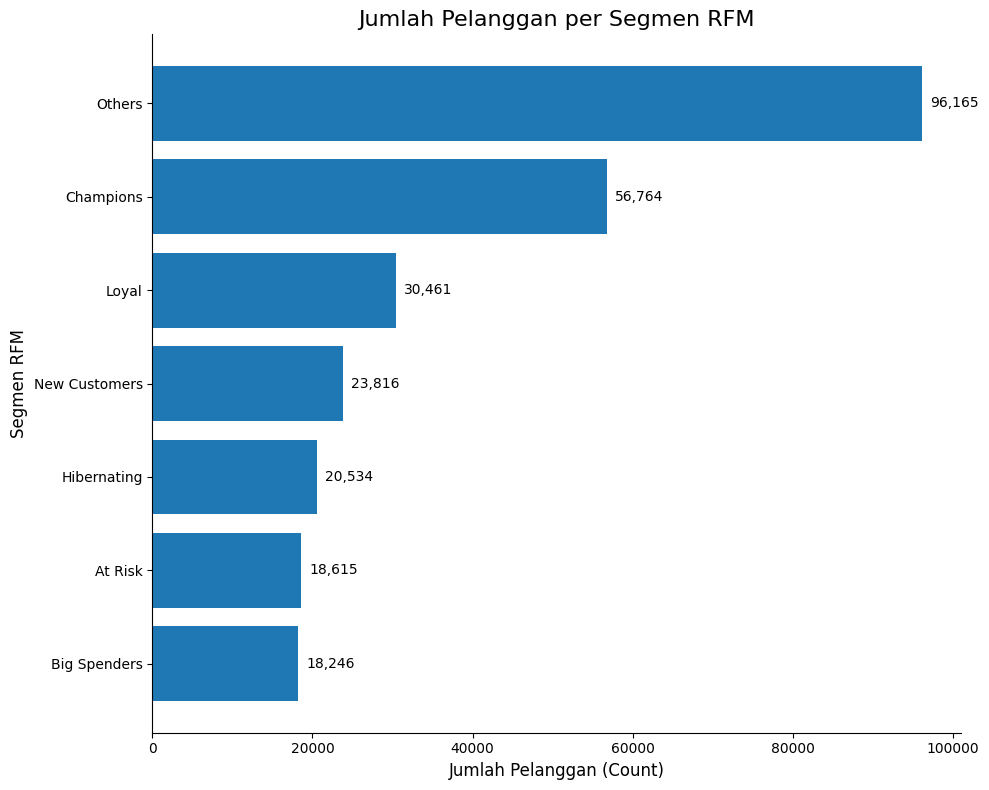

In [37]:
seg_counts_sorted = seg_counts.sort_values(by="count", ascending=True)

plt.figure(figsize=(10, 8)) 

bars = plt.barh(seg_counts_sorted["segment"].astype(str), seg_counts_sorted["count"])

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1000,  
             bar.get_y() + bar.get_height() / 2,
             f'{width:,}', 
             va='center')

plt.title("Jumlah Pelanggan per Segmen RFM", fontsize=16)
plt.xlabel("Jumlah Pelanggan (Count)", fontsize=12)
plt.ylabel("Segmen RFM", fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

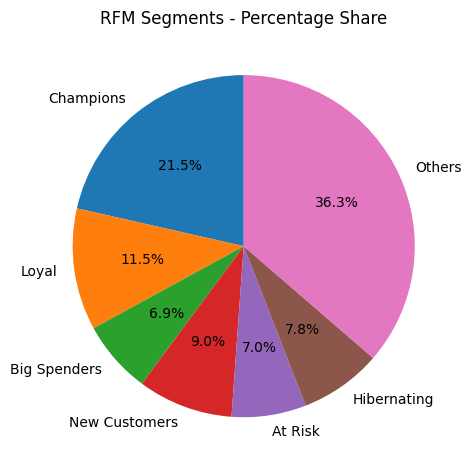

In [27]:
plt.figure()
plt.pie(seg_counts["count"], labels=seg_counts["segment"].astype(str), autopct="%1.1f%%", startangle=90)
plt.title("RFM Segments - Percentage Share")
plt.tight_layout()
plt.savefig("rfm_segment_share_pie.png", dpi=150)
plt.show()

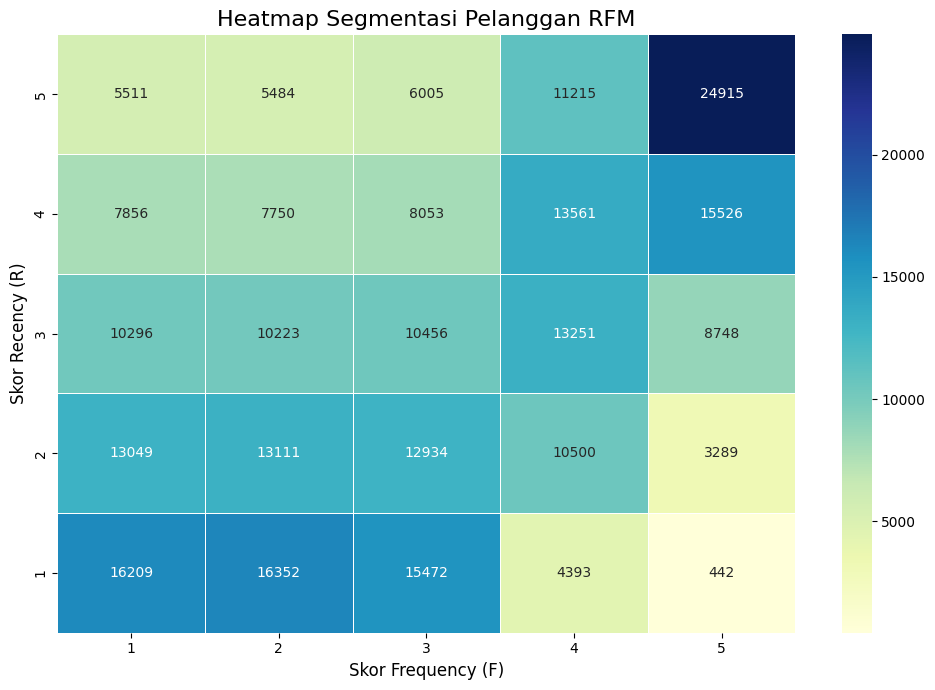

In [35]:
rf_bins, f_bins = 5, 5
R_labels = list(range(rf_bins, 0, -1))      # 5..1 (5=Sangat Baru)
F_labels = list(range(1, f_bins + 1))       # 1..5 (5=Sangat Sering)

rfm["_F_rank"] = rfm["frequency"].rank(method="first")
rfm["_R_bin"] = pd.qcut(rfm["recency"], rf_bins, labels=R_labels)
rfm["_F_bin"] = pd.qcut(rfm["_F_rank"], f_bins, labels=F_labels)

pivot_rf = rfm.pivot_table(index="_R_bin", columns="_F_bin", values="customer_name", aggfunc="count", fill_value=0, observed=False)

plt.figure(figsize=(10, 7))

sns.heatmap(pivot_rf, 
            annot=True,          
            fmt='d',             
            cmap="YlGnBu",       
            linewidths=.5)     

plt.title("Heatmap Segmentasi Pelanggan RFM", fontsize=16)
plt.ylabel("Skor Recency (R)", fontsize=12)
plt.xlabel("Skor Frequency (F)", fontsize=12)

plt.tight_layout()
plt.show()